# HS Spring 2020 Data Analysis

#### Importing libraries below:

In [4]:
import numpy as np
import scipy.stats as scs
import math
import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib
import matplotlib.pyplot as plt

import re
import argparse
import logging

import os
# import glob
import sys
from pathlib import Path

from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist

import gamework

In [19]:
from seaborn import heatmap

### Utility Functions:

In [5]:
def q_summary_V1(numbers):
    '''
    This function takes in a list of numbers and uses numpy quantile functions
    to calculate quartile1, quartile2, and quartile3. This function also determines
    if there are any outliers in the input set.
    '''
    nums = sorted(numbers)
    q1 = np.quantile(nums, 0.25)
    q2 = np.quantile(nums, 0.5)
    q3 = np.quantile(nums, 0.75)
    iqr = q3 - q1
    lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr
    
    outs, safe = [], []
    for n in nums:
        if n >= lower and n <= upper:
            safe.append(n)
        else:
            outs.append(n)
    print('The following are outliers: {}'.format(outs))
    d = {'min':min(safe), 'q1':q1, 'q2':q2, 'q3':q3, 'max':max(safe)}
    return d

In [6]:
def generate_histograms_score_matchup(score_score, matchup_name, save_dir=None, ngames=390):
    '''
    This function takes as input a gamework.MatchupData() object and outputs into save_dir
    the histogram of the probability of the frequency of the number of turns per game.
    
    TODO - PUT THIS BACK TO NON-PDF (raw # games)
    
    '''
    d = {}

    for file in score_score.get_folders():
        match = gamework.MatchData(file, ngames)
        matchup_ = file.split('\\')[-1].strip('.csv')
        turns_groups = match.df.groupby('GAME_COUNTER').count()
        turns_groups.reset_index(inplace=True)
        d[matchup_] = turns_groups[['GAME_COUNTER', 'TURN_NO']]
        
    try:
        if save_dir is None:
            save_dir = 'C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-output'
        root_output_dir = os.path.join(save_dir, 'num-turns-per-game')
        if not os.path.exists(root_output_dir):
            os.mkdir(root_output_dir)
            print('Made directory: {}'.format(root_output_dir))
    except:
        print('There was a problem making', root_output_dir)
        return
    try:
        output_dir = os.path.join(root_output_dir, matchup_name)
        if not os.path.exists(output_dir):
            os.mkdir(output_dir)
            print('Made directory: {}'.format(output_dir))
    except:
        print('There was a problem making', output_dir)
        return
    for matchup in d:
        
        output_file = os.path.join(output_dir, '{}-Hist.jpg'.format(matchup))
        bin_list = sorted(d[matchup]['TURN_NO'].unique())
        bin_list.append(max(bin_list) + 1)
        values_to_plot = d[matchup]['TURN_NO']
        mu = values_to_plot.mean()
        sigma = values_to_plot.std()

        n_, bins_, patches_ = plt.hist(values_to_plot, bins=bin_list, density=1)

        y = scs.norm.pdf(bins_, mu, sigma)

        plt.plot(bins_, y, 'r--')
        plt.title('PDF How Many Turns in Each Game for {}'.format(matchup))
        plt.xlabel('Number of Turns')
        plt.ylabel('Probability')
        plt.subplots_adjust(left=0.15)
        plt.savefig(output_file)
        print('Wrote histogram to: {}'.format(output_file))
        plt.clf()
        plt.close()
    return d

In [7]:
def find_num_turn_outliers(d):
    '''
    This function takes as input the dictionary object returned from generate_histograms,
    and determines if any of the matchups have outliers in the number of turns
    '''
    for matchup in d:
        print(matchup)
        vals_to_check = sorted(d[matchup]['TURN_NO'].values)
        print(q_summary_V1(vals_to_check))
        print('_________')

In [8]:
def get_val(df, m, v):
    try:
        x = df.loc[(v, m)]
        return x
    except:
        print('Check {} in df {}'.format(v, m))

def diff_in_means(df1, df2, m1, m2):
    x1 = get_val(df1, m1, 'Mean-Num-Turns')
    x2 = get_val(df2, m2, 'Mean-Num-Turns')
    if x1 is None or x2 is None:
        return
    dif = x1-x2
    if dif < 0:
        print('difference is negative')
        return dif
    return abs(dif)
    

def samp_stat(df1, df2, m1, m2, z):
    s1 = get_val(df1, m1, 'Std-Num-Turns')
    print(m1, s1)
    s2 = get_val(df2, m2, 'Std-Num-Turns')
    print(m2, s2)
    n1 = get_val(df1, m1, 'Num-Games')
    print(m1, n1)
    n2 = get_val(df2, m2, 'Num-Games')
    print(m2, n2)
    if s1 is None or s2 is None or n1 is None or n2 is None:
        return
    vss = math.sqrt((s1**2 / n1) + (s2**2 / n2))
    print('Std sampling distribution is', vss)
    return z* vss

In [9]:
def get_matchups_winrates(score_score, ngames=390):
    d = {}

    for file in score_score.get_folders():
        match = gamework.MatchData(file, ngames)
        matchup_ = file.split('\\')[-1].strip('.csv')
        player_names = matchup_.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        relevant_cols = ['TURN_NO', 'P1_HEALTH', 'P2_HEALTH', 'GAME_COUNTER']
        p1_wins = match.df.loc[(match.df['P2_HEALTH']<=0)][relevant_cols]
        p2_wins = match.df.loc[(match.df['P1_HEALTH']<=0)][relevant_cols]
        
        p1_n_wins = p1_wins.shape[0]
        p2_n_wins = p2_wins.shape[0]
        
        p1_wr = p1_n_wins/ngames
        p2_wr = p2_n_wins/ngames
        
        
        d[matchup_] = {p1name:{'Wins':p1_wins, 'NumWins':p1_n_wins, 'Winrate':p1_wr }, 
                       p2name:{'Wins':p2_wins, 'NumWins':p2_n_wins, 'Winrate':p2_wr}}
    return d

In [10]:
def get_winrates_for_matchup_asframe(score_score_wins):
    p1list = []
    p2list = []
    for key in score_score_wins:
        player_names = key.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        p1list.append(p1name)
        p2list.append(p2name)
        print(key, '\t', score_score_wins[key][p1name]['Winrate'])
    p1_unique = pd.Series(p1list).unique()
    p2_unique = pd.Series(p2list).unique()
    wrdf = pd.DataFrame(columns=p2_unique, index=p1_unique)
    for key in score_score_wins:
        player_names = key.split('-')
        p1name = 'P1-{}'.format(player_names[0])
        p2name = 'P2-{}'.format(player_names[1])
        wrdf.loc[p1name, p2name] = score_score_wins[key][p1name]['Winrate']
    return wrdf

In [11]:
def get_cleaned_match_df(folder):
    df = pd.read_csv(folder, index_col=0)
    player_names = df['CURRENT_PLAYER'].unique()
    p1, p2 = '', ''
    for pn in player_names:
        if 'P1' in pn:
            p1 = pn
        else:
            p2 = pn
    df.loc[df['CURRENT_PLAYER'] == p1, 'CURRENT_PLAYER'] = 1
    df.loc[df['CURRENT_PLAYER'] == p2, 'CURRENT_PLAYER'] = 2
    df.loc[:, 'CURRENT_PLAYER'] = df.loc[:, 'CURRENT_PLAYER'].astype(int)
    return df

In [12]:
def get_games_min_num_turns(df):
    min_n_turns = df.groupby('GAME_COUNTER').count()['TURN_NO'].min()
    print('min_n_turns is:', min_n_turns)
    df_games_minturns = df.loc[(df['TURN_NO'].isin(range(0, min_n_turns+1)))]
    # df_games_min8.loc[(df_games_min['TURN_NO']>min_n_turns)]
    return df_games_minturns

In [13]:
def get_featurevector_gameset(df, suppress=True):
    num_turns = int(df.shape[0]/df['GAME_COUNTER'].max())
    cols = list(df.iloc[:, :-1].columns) # take out the GAME_COUNTER column
    all_cols = []
    for i in range(num_turns):
        for col in cols:
            all_cols += ['{}-{}'.format(col, i)]
    
    df_trans = pd.DataFrame(df.iloc[:, :-1].values.reshape(df['GAME_COUNTER'].max(), len(all_cols)), columns=all_cols)

    if not suppress:
        for dataT in df_trans.dtypes:
            print(dataT, end="\t")
        
    return df_trans

In [14]:
def get_principal_components(df, ncomp=2):
    data_scaled = pd.DataFrame(preprocessing.scale(df),columns = df.columns)
    pca = PCA(n_components=ncomp)
    projected_data = pca.fit_transform(data_scaled)
    print('Explained Variance Ratio:\n{}'.format(pca.explained_variance_ratio_))
    print('Singular Values:\n{}'.format(pca.singular_values_))
    pc_1_2 = pd.DataFrame(pca.components_,columns=data_scaled.columns,index = ['PC-1','PC-2'])
    pc_1_2_T = pc_1_2.transpose()
    pc_1_2_T.sort_values('PC-1', inplace=True)
    pc_1_2_T['PC-1-ABS'] = pc_1_2_T['PC-1'].abs()
    pc_1_2_T['PC-2-ABS'] = pc_1_2_T['PC-2'].abs()
    return pc_1_2_T, projected_data

In [31]:
def get_winrates_heatmap_formatchup(mm_sdf, s1, s2):
    '''
    mm_sdf - DF returned with the stats for all games in a given matchup
    s1 - scoring function 1
    s2 - scoring function 2
    '''
    mmp1_winratess = mm_sdf.iloc[6,:]
    mmp1_wr = mmp1_winratess.values.reshape(5,5)
    mmp1_wr = mmp1_wr.round(2)
    mm_players1 = []
    mm_players2 = []
    for match in mmp1_winratess.index.values:
        p1 = match.split('-')[0]
        p2 = match.split('-')[1]
        if p1 not in mm_players1:
            mm_players1.append(p1)
        if p2 not in mm_players2:
            mm_players2.append(p2)
    #print(ac_players1)
    #print(ac_players2)
    ax = plt.axes()
    heatmap(mmp1_wr, annot=True, xticklabels=mm_players2, yticklabels=mm_players1, ax=ax, vmin=0, vmax=100)#, cmap="RdBu")
    ax.xaxis.set_ticks_position('top')
    for tick in ax.get_yticklabels():
        tick.set_rotation(0)
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.set_title('{} vs {} Winrates'.format(s1, s2))
    plt.show()
    return pd.DataFrame(mmp1_wr, columns=mm_players2, index=mm_players1)

### Collecting the data for Aggro-Aggro matchups

In [16]:
place = 'laptop'
if place == 'mixr':
    root_dir = 'C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups'
else:
    root_dir = 'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups'

In [17]:
aa_folder = root_dir + '\\AvsA_1k0_Compiled\\'
agg_agg = gamework.MatchupData('aggro', 'aggro', aa_folder, 390)
agg_agg_folders = agg_agg.get_folders()
sdf = agg_agg.get_all_matchup_summary_data()
sdf

Roffle-Roffle (4071, 23)
Roffle-Viper (4216, 23)
Roffle-Pizza (4112, 23)
Roffle-Solegit (4177, 23)
Roffle-Wabeka (4323, 23)
Viper-Roffle (4221, 23)
Viper-Viper (4240, 23)
Viper-Pizza (4233, 23)
Viper-Solegit (4235, 23)
Viper-Wabeka (4509, 23)
Pizza-Roffle (4116, 23)
Pizza-Viper (4238, 23)
Pizza-Pizza (4216, 23)
Pizza-Solegit (4172, 23)
Pizza-Wabeka (4363, 23)
Solegit-Roffle (4088, 23)
Solegit-Viper (4263, 23)
Solegit-Pizza (4195, 23)
Solegit-Solegit (4162, 23)
Solegit-Wabeka (4371, 23)
Wabeka-Roffle (4373, 23)
Wabeka-Viper (4441, 23)
Wabeka-Pizza (4373, 23)
Wabeka-Solegit (4375, 23)
Wabeka-Wabeka (4664, 23)


,Roffle-Roffle,Roffle-Viper,Roffle-Pizza,Roffle-Solegit,Roffle-Wabeka,Viper-Roffle,Viper-Viper,Viper-Pizza,Viper-Solegit,Viper-Wabeka,Pizza-Roffle,Pizza-Viper,Pizza-Pizza,Pizza-Solegit,Pizza-Wabeka,Solegit-Roffle,Solegit-Viper,Solegit-Pizza,Solegit-Solegit,Solegit-Wabeka,Wabeka-Roffle,Wabeka-Viper,Wabeka-Pizza,Wabeka-Solegit,Wabeka-Wabeka
Max-Num-Turns,15.000000,18.000000,16.000000,14.000000,20.000000,15.000000,17.000000,16.000000,15.000000,18.000000,15.000000,15.000000,16.000000,16.000000,17.000000,15.000000,15.000000,15.000000,16.000000,16.000000,16.000000,17.000000,17.000000,17.000000,17.000000
Mean-Num-Turns,10.465296,10.838046,10.570694,10.737789,11.113111,10.850900,10.899743,10.881748,10.886889,11.591260,10.580977,10.894602,10.838046,10.724936,11.215938,10.508997,10.958869,10.784062,10.699229,11.236504,11.241645,11.416452,11.241645,11.246787,11.989717
Median-Num-Turns,10.000000,11.000000,10.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,10.000000,11.000000,11.000000,11.000000,11.000000,10.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,11.000000,12.000000
Min-Num-Turns,8.000000,7.000000,7.000000,7.000000,7.000000,8.000000,8.000000,9.000000,8.000000,9.000000,8.000000,8.000000,8.000000,8.000000,9.000000,8.000000,8.000000,8.000000,7.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
Num-Games,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000
P1-NWins,192.000000,177.000000,205.000000,199.000000,216.000000,195.000000,181.000000,199.000000,219.000000,243.000000,194.000000,183.000000,187.000000,183.000000,226.000000,176.000000,173.000000,184.000000,193.000000,200.000000,159.000000,141.000000,189.000000,180.000000,199.000000
P1-Win%,49.357326,45.501285,52.699229,51.156812,55.526992,50.128535,46.529563,51.156812,56.298201,62.467866,49.871465,47.043702,48.071979,47.043702,58.097686,45.244216,44.473008,47.300771,49.614396,51.413882,40.874036,36.246787,48.586118,46.272494,51.156812
P2-NWins,198.000000,212.000000,186.000000,191.000000,176.000000,196.000000,209.000000,192.000000,171.000000,146.000000,195.000000,206.000000,203.000000,207.000000,163.000000,214.000000,217.000000,206.000000,197.000000,189.000000,230.000000,250.000000,201.000000,211.000000,192.000000
P2-Win%,50.899743,54.498715,47.814910,49.100257,45.244216,50.385604,53.727506,49.357326,43.958869,37.532134,50.128535,52.956298,52.185090,53.213368,41.902314,55.012853,55.784062,52.956298,50.642674,48.586118,59.125964,64.267352,51.670951,54.241645,49.357326
Std-Num-Turns,1.299069,1.449135,1.244893,1.244839,1.626950,1.287682,1.458259,1.252380,1.307219,1.646623,1.252522,1.235930,1.147383,1.185792,1.502456,1.204821,1.279640,1.239244,1.168541,1.427132,1.562516,1.601010,1.481227,1.421764,1.657503


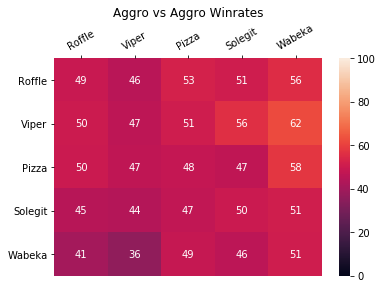

,Roffle,Viper,Pizza,Solegit,Wabeka
Roffle,49.36,45.50,52.70,51.16,55.53
Viper,50.13,46.53,51.16,56.30,62.47
Pizza,49.87,47.04,48.07,47.04,58.10
Solegit,45.24,44.47,47.30,49.61,51.41
Wabeka,40.87,36.25,48.59,46.27,51.16


In [32]:
get_winrates_heatmap_formatchup(sdf, "Aggro", "Aggro")

### Collecting the data for Aggro-Control matchups

In [23]:
ac_folder = root_dir + '\\AvsC_1k0_Compiled\\'
agg_con = gamework.MatchupData('aggro', 'control', ac_folder, 390)
agg_con.get_matchups()
agg_con_folders = agg_con.get_folders()
ac_sdf = agg_con.get_all_matchup_summary_data()

Roffle-Orasha.csv
Roffle-Thijs.csv
Roffle-Stonekeep.csv
Roffle-Slage.csv
Roffle-Krebs1996.csv
Viper-Orasha.csv
Viper-Thijs.csv
Viper-Stonekeep.csv
Viper-Slage.csv
Viper-Krebs1996.csv
Pizza-Orasha.csv
Pizza-Thijs.csv
Pizza-Stonekeep.csv
Pizza-Slage.csv
Pizza-Krebs1996.csv
Solegit-Orasha.csv
Solegit-Thijs.csv
Solegit-Stonekeep.csv
Solegit-Slage.csv
Solegit-Krebs1996.csv
Wabeka-Orasha.csv
Wabeka-Thijs.csv
Wabeka-Stonekeep.csv
Wabeka-Slage.csv
Wabeka-Krebs1996.csv
Total 25 matchups
Roffle-Orasha (7948, 23)
Roffle-Thij (7949, 23)
Roffle-Stonekeep (7368, 23)
Roffle-Slage (7603, 23)
Roffle-Krebs1996 (7237, 23)
Viper-Orasha (8250, 23)
Viper-Thij (8053, 23)
Viper-Stonekeep (7555, 23)
Viper-Slage (7729, 23)
Viper-Krebs1996 (7505, 23)
Pizza-Orasha (8099, 23)
Pizza-Thij (8023, 23)
Pizza-Stonekeep (7550, 23)
Pizza-Slage (7506, 23)
Pizza-Krebs1996 (7309, 23)
Solegit-Orasha (8062, 23)
Solegit-Thij (7726, 23)
Solegit-Stonekeep (7406, 23)
Solegit-Slage (7487, 23)
Solegit-Krebs1996 (7285, 23)
Wabeka-Ora

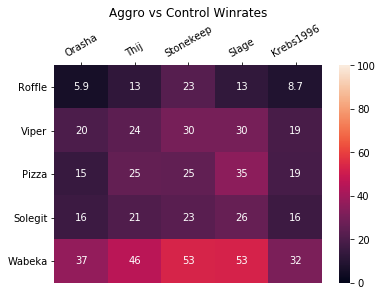

,Orasha,Thij,Stonekeep,Slage,Krebs1996
Roffle,5.91,12.85,22.62,13.11,8.74
Viper,20.05,24.16,30.33,30.08,18.77
Pizza,14.65,25.45,25.19,35.48,18.51
Solegit,15.68,20.82,23.14,26.48,16.20
Wabeka,36.76,45.76,53.21,52.96,31.62


In [33]:
get_winrates_heatmap_formatchup(ac_sdf, "Aggro", "Control")

In [15]:
ac_sdf[list(ac_sdf.columns)[:5]].loc[('Mean-Num-Turns')].mean()

19.652442159383035

# Collecting the data for the Control-Control matchups

In [27]:
cc_folder = root_dir + '\\CvsC_1k0_Compiled\\'
con_con = gamework.MatchupData('control', 'control', cc_folder)
con_con.get_matchups()
con_con_folders = con_con.get_folders()
cc_sdf = con_con.get_all_matchup_summary_data()
cc_sdf

Orasha-Orasha.csv
Orasha-Thijs.csv
Orasha-Stonekeep.csv
Orasha-Slage.csv
Orasha-Krebs1996.csv
Thijs-Orasha.csv
Thijs-Thijs.csv
Thijs-Stonekeep.csv
Thijs-Slage.csv
Thijs-Krebs1996.csv
Stonekeep-Orasha.csv
Stonekeep-Thijs.csv
Stonekeep-Stonekeep.csv
Stonekeep-Slage.csv
Stonekeep-Krebs1996.csv
Slage-Orasha.csv
Slage-Thijs.csv
Slage-Stonekeep.csv
Slage-Slage.csv
Slage-Krebs1996.csv
Krebs1996-Orasha.csv
Krebs1996-Thijs.csv
Krebs1996-Stonekeep.csv
Krebs1996-Slage.csv
Krebs1996-Krebs1996.csv
Total 25 matchups
Orasha-Orasha (17838, 23)
Orasha-Thij (18816, 23)
Orasha-Stonekeep (19644, 23)
Orasha-Slage (17670, 23)
Orasha-Krebs1996 (18972, 23)
Thijs-Orasha (18598, 23)
Thijs-Thij (19268, 23)
Thijs-Stonekeep (20904, 23)
Thijs-Slage (18644, 23)
Thijs-Krebs1996 (20157, 23)
Stonekeep-Orasha (19876, 23)
Stonekeep-Thij (20939, 23)
Stonekeep-Stonekeep (25500, 23)
Stonekeep-Slage (19021, 23)
Stonekeep-Krebs1996 (21139, 23)
Slage-Orasha (17327, 23)
Slage-Thij (17624, 23)
Slage-Stonekeep (18460, 23)
Slage-S

,Orasha-Orasha,Orasha-Thij,Orasha-Stonekeep,Orasha-Slage,Orasha-Krebs1996,Thijs-Orasha,Thijs-Thij,Thijs-Stonekeep,Thijs-Slage,Thijs-Krebs1996,Stonekeep-Orasha,Stonekeep-Thij,Stonekeep-Stonekeep,Stonekeep-Slage,Stonekeep-Krebs1996,Slage-Orasha,Slage-Thij,Slage-Stonekeep,Slage-Slage,Slage-Krebs1996,Krebs1996-Orasha,Krebs1996-Thij,Krebs1996-Stonekeep,Krebs1996-Slage,Krebs1996-Krebs1996
Max-Num-Turns,44.000000,45.000000,51.000000,46.000000,47.000000,47.000000,46.000000,52.000000,46.000000,47.000000,49.000000,54.000000,57.000000,52.000000,51.000000,44.000000,46.000000,49.000000,46.000000,48.000000,44.000000,46.000000,51.000000,46.000000,49.000000
Mean-Num-Turns,26.270987,27.711340,28.510885,25.947137,27.455861,27.390280,28.887556,30.427948,27.138282,29.170767,28.973761,30.657394,36.637931,28.096012,30.459654,25.861194,26.703030,28.312883,26.049536,27.093846,27.858195,29.363465,30.084270,27.090038,29.382692
Median-Num-Turns,25.000000,27.000000,28.000000,25.000000,26.000000,26.000000,28.000000,30.000000,26.000000,29.000000,28.000000,30.000000,37.000000,27.000000,30.000000,26.000000,26.000000,28.000000,25.000000,26.000000,27.000000,28.000000,30.000000,26.000000,28.000000
Min-Num-Turns,15.000000,16.000000,14.000000,15.000000,14.000000,12.000000,17.000000,14.000000,16.000000,14.000000,14.000000,15.000000,14.000000,12.000000,10.000000,15.000000,15.000000,11.000000,15.000000,16.000000,15.000000,11.000000,11.000000,14.000000,16.000000
Num-Games,680.000000,680.000000,690.000000,682.000000,692.000000,680.000000,668.000000,688.000000,688.000000,692.000000,687.000000,684.000000,697.000000,678.000000,695.000000,671.000000,661.000000,653.000000,647.000000,651.000000,544.000000,532.000000,535.000000,523.000000,521.000000
P1-NWins,345.000000,266.000000,218.000000,360.000000,318.000000,400.000000,351.000000,263.000000,427.000000,394.000000,452.000000,387.000000,354.000000,453.000000,434.000000,314.000000,252.000000,217.000000,338.000000,232.000000,256.000000,197.000000,200.000000,273.000000,241.000000
P1-Win%,50.810015,39.175258,31.640058,52.863436,46.020260,58.910162,52.623688,38.282387,62.154294,57.018813,65.889213,56.661786,50.862069,66.912851,62.536023,46.865672,38.181818,33.282209,52.321981,35.692308,47.145488,37.099812,37.453184,52.298851,46.346154
P2-NWins,336.000000,416.000000,472.000000,323.000000,373.000000,281.000000,319.000000,427.000000,265.000000,296.000000,233.000000,297.000000,345.000000,230.000000,267.000000,358.000000,408.000000,434.000000,307.000000,420.000000,292.000000,334.000000,335.000000,252.000000,276.000000
P2-Win%,49.484536,61.266568,68.505080,47.430250,53.979740,41.384389,47.826087,62.154294,38.573508,42.836469,33.965015,43.484627,49.568966,33.973412,38.472622,53.432836,61.818182,66.564417,47.523220,64.615385,53.775322,62.900188,62.734082,48.275862,53.076923
Std-Num-Turns,5.240265,5.528076,6.823370,5.294572,6.091501,5.526495,5.951073,7.519477,5.495010,6.332782,7.017343,7.622877,9.313930,6.451315,8.012109,4.853318,5.259256,6.803380,5.357660,5.350759,5.922638,6.666567,7.762324,5.415335,6.121890


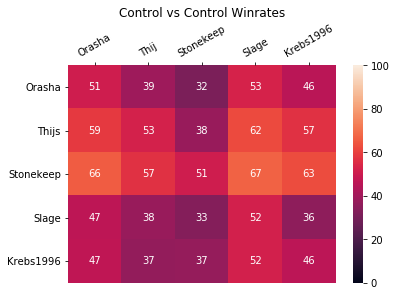

,Orasha,Thij,Stonekeep,Slage,Krebs1996
Orasha,50.81,39.18,31.64,52.86,46.02
Thijs,58.91,52.62,38.28,62.15,57.02
Stonekeep,65.89,56.66,50.86,66.91,62.54
Slage,46.87,38.18,33.28,52.32,35.69
Krebs1996,47.15,37.10,37.45,52.30,46.35


In [34]:
get_winrates_heatmap_formatchup(cc_sdf, "Control", "Control")

# Collecting the data for Control-NNControl Matchups

In [29]:
cnc_folder = root_dir + '\\CvsNNC_1k02_Compiled\\'
con_cnc = gamework.MatchupData('control', 'nncontrol', cnc_folder)
con_cnc.get_matchups()
con_cnc_folders = con_cnc.get_folders()
cnc_sdf = con_cnc.get_all_matchup_summary_data()
cnc_sdf

Orasha-NNOrasha.csv
Orasha-NNThijs.csv
Orasha-NNStonekeep.csv
Orasha-NNSlage.csv
Orasha-NNKrebs1996.csv
Thijs-NNOrasha.csv
Thijs-NNThijs.csv
Thijs-NNStonekeep.csv
Thijs-NNSlage.csv
Thijs-NNKrebs1996.csv
Stonekeep-NNOrasha.csv
Stonekeep-NNThijs.csv
Stonekeep-NNStonekeep.csv
Stonekeep-NNSlage.csv
Stonekeep-NNKrebs1996.csv
Slage-NNOrasha.csv
Slage-NNThijs.csv
Slage-NNStonekeep.csv
Slage-NNSlage.csv
Slage-NNKrebs1996.csv
Krebs1996-NNOrasha.csv
Krebs1996-NNThijs.csv
Krebs1996-NNStonekeep.csv
Krebs1996-NNSlage.csv
Krebs1996-NNKrebs1996.csv
Total 25 matchups
Orasha-NNOrasha (9270, 23)
Orasha-NNThij (8518, 23)
Orasha-NNStonekeep (8519, 23)
Orasha-NNSlage (9393, 23)
Orasha-NNKrebs1996 (9516, 23)
Thijs-NNOrasha (9672, 23)
Thijs-NNThij (8823, 23)
Thijs-NNStonekeep (8967, 23)
Thijs-NNSlage (9573, 23)
Thijs-NNKrebs1996 (10148, 23)
Stonekeep-NNOrasha (9961, 23)
Stonekeep-NNThij (9180, 23)
Stonekeep-NNStonekeep (9519, 23)
Stonekeep-NNSlage (9752, 23)
Stonekeep-NNKrebs1996 (10463, 23)
Slage-NNOrasha (

,Orasha-NNOrasha,Orasha-NNThij,Orasha-NNStonekeep,Orasha-NNSlage,Orasha-NNKrebs1996,Thijs-NNOrasha,Thijs-NNThij,Thijs-NNStonekeep,Thijs-NNSlage,Thijs-NNKrebs1996,Stonekeep-NNOrasha,Stonekeep-NNThij,Stonekeep-NNStonekeep,Stonekeep-NNSlage,Stonekeep-NNKrebs1996,Slage-NNOrasha,Slage-NNThij,Slage-NNStonekeep,Slage-NNSlage,Slage-NNKrebs1996,Krebs1996-NNOrasha,Krebs1996-NNThij,Krebs1996-NNStonekeep,Krebs1996-NNSlage,Krebs1996-NNKrebs1996
Max-Num-Turns,40.000000,38.000000,38.000000,40.000000,42.000000,44.000000,41.000000,39.000000,38.000000,45.000000,44.000000,46.000000,42.000000,45.000000,42.000000,39.000000,40.000000,40.000000,38.000000,44.000000,40.000000,40.000000,40.000000,40.000000,40.000000
Mean-Num-Turns,23.647959,21.619289,21.512626,23.840102,23.909548,24.863753,23.036554,22.758883,24.420918,25.821883,25.606684,23.299492,23.917085,25.134021,26.288945,22.355330,20.480818,19.230380,22.858247,22.785714,23.503778,19.696970,18.894472,23.420253,24.138191
Median-Num-Turns,23.000000,22.000000,21.000000,23.000000,24.000000,25.000000,23.000000,22.000000,24.000000,24.000000,25.000000,22.000000,23.000000,25.000000,26.000000,23.000000,20.000000,19.000000,22.000000,23.000000,23.000000,19.000000,17.000000,23.000000,24.000000
Min-Num-Turns,13.000000,13.000000,13.000000,12.000000,13.000000,13.000000,13.000000,11.000000,14.000000,12.000000,13.000000,13.000000,13.000000,10.000000,10.000000,11.000000,9.000000,9.000000,11.000000,11.000000,9.000000,9.000000,9.000000,9.000000,11.000000
Num-Games,393.000000,395.000000,397.000000,395.000000,399.000000,390.000000,384.000000,395.000000,393.000000,394.000000,390.000000,395.000000,399.000000,389.000000,399.000000,395.000000,392.000000,396.000000,389.000000,393.000000,398.000000,397.000000,399.000000,396.000000,399.000000
P1-NWins,237.000000,275.000000,237.000000,219.000000,191.000000,275.000000,288.000000,281.000000,265.000000,188.000000,296.000000,328.000000,351.000000,255.000000,266.000000,232.000000,278.000000,283.000000,217.000000,186.000000,258.000000,294.000000,330.000000,254.000000,191.000000
P1-Win%,60.459184,69.796954,59.848485,55.583756,47.989950,70.694087,75.195822,71.319797,67.602041,47.837150,76.092545,83.248731,88.190955,65.721649,66.834171,58.883249,71.099744,71.645570,55.927835,47.448980,64.987406,74.242424,82.914573,64.303797,47.989950
P2-NWins,159.000000,119.000000,160.000000,176.000000,210.000000,115.000000,98.000000,112.000000,128.000000,202.000000,92.000000,68.000000,47.000000,133.000000,134.000000,165.000000,115.000000,113.000000,172.000000,206.000000,137.000000,101.000000,68.000000,139.000000,206.000000
P2-Win%,40.561224,30.203046,40.404040,44.670051,52.763819,29.562982,25.587467,28.426396,32.653061,51.399491,23.650386,17.258883,11.809045,34.278351,33.668342,41.878173,29.411765,28.607595,44.329897,52.551020,34.508816,25.505051,17.085427,35.189873,51.758794
Std-Num-Turns,5.238413,6.288423,5.502344,4.919434,5.303567,5.535681,6.220530,6.141689,5.054574,6.398647,6.624467,7.919869,7.532677,5.902969,7.246257,5.581288,6.395031,5.430698,4.571907,5.529276,6.569605,7.226119,6.305323,5.162889,6.043795


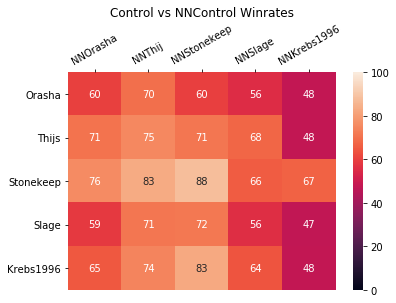

,NNOrasha,NNThij,NNStonekeep,NNSlage,NNKrebs1996
Orasha,60.46,69.80,59.85,55.58,47.99
Thijs,70.69,75.20,71.32,67.60,47.84
Stonekeep,76.09,83.25,88.19,65.72,66.83
Slage,58.88,71.10,71.65,55.93,47.45
Krebs1996,64.99,74.24,82.91,64.30,47.99


In [35]:
get_winrates_heatmap_formatchup(cnc_sdf, "Control", "NNControl")

# Getting Data for Aggro-NNAggro Matchups

In [36]:
ana_folder = root_dir + '\\AvsNNA_1k02_Compiled\\'
agg_ana = gamework.MatchupData('aggro', 'nnaggro', ana_folder)
agg_ana.get_matchups()
agg_ana_folders = agg_ana.get_folders()
ana_sdf = agg_ana.get_all_matchup_summary_data()

Roffle-NNRoffle.csv
Roffle-NNViper.csv
Roffle-NNPizza.csv
Roffle-NNSolegit.csv
Roffle-NNWabeka.csv
Viper-NNRoffle.csv
Viper-NNViper.csv
Viper-NNPizza.csv
Viper-NNSolegit.csv
Viper-NNWabeka.csv
Pizza-NNRoffle.csv
Pizza-NNViper.csv
Pizza-NNPizza.csv
Pizza-NNSolegit.csv
Pizza-NNWabeka.csv
Solegit-NNRoffle.csv
Solegit-NNViper.csv
Solegit-NNPizza.csv
Solegit-NNSolegit.csv
Solegit-NNWabeka.csv
Wabeka-NNRoffle.csv
Wabeka-NNViper.csv
Wabeka-NNPizza.csv
Wabeka-NNSolegit.csv
Wabeka-NNWabeka.csv
Total 25 matchups
Roffle-NNRoffle (4491, 23)
Roffle-NNViper (4569, 23)
Roffle-NNPizza (4584, 23)
Roffle-NNSolegit (4487, 23)
Roffle-NNWabeka (4712, 23)
Viper-NNRoffle (4186, 23)
Viper-NNViper (4312, 23)
Viper-NNPizza (4074, 23)
Viper-NNSolegit (3950, 23)
Viper-NNWabeka (4252, 23)
Pizza-NNRoffle (3781, 23)
Pizza-NNViper (3866, 23)
Pizza-NNPizza (3930, 23)
Pizza-NNSolegit (3819, 23)
Pizza-NNWabeka (4052, 23)
Solegit-NNRoffle (3765, 23)
Solegit-NNViper (3923, 23)
Solegit-NNPizza (3887, 23)
Solegit-NNSolegit 

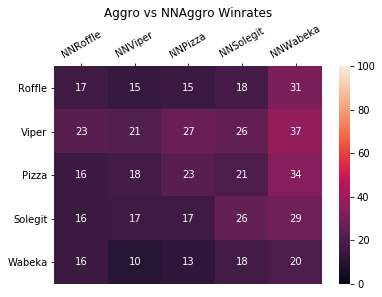

,NNRoffle,NNViper,NNPizza,NNSolegit,NNWabeka
Roffle,17.01,14.77,15.32,18.06,31.43
Viper,23.02,21.14,26.97,25.57,36.72
Pizza,15.67,17.73,22.92,20.52,34.01
Solegit,16.18,16.62,16.71,26.16,28.53
Wabeka,15.80,10.40,12.68,17.73,20.23


In [37]:
get_winrates_heatmap_formatchup(ana_sdf, "Aggro", "NNAggro")

# Aggro-Aggro PCA

This methodology is suggested by Prof. Roshan

In [54]:
agg_agg_folders[0]

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups\\AvsA_1k0_Compiled\\Roffle-Roffle.csv'

In [55]:
aa_rr

,TURN_NO,P1_HEALTH,P2_HEALTH,CURRENT_PLAYER,AMOUNTHEALEDTHISTURN,NUMATTACKSTHISTURN,NUMCARDSDRAWNTHISTURN,NUMCARDSPLAYEDTHISTURN,NUMCARDSTODRAW,NUMELEMENTALSPLAYEDLASTTURN,NUMELEMENTALSPLAYEDTHISTURN,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN,NUMFRIENDLYMINIONSTHATDIEDTHISTURN,NUMMINIONSPLAYEDTHISTURN,NUMMINIONSPLAYERKILLEDTHISTURN,NUMOPTIONSPLAYEDTHISTURN,NUMSECRETSPLAYEDTHISGAME,NUMSPELLSPLAYEDTHISGAME,NUMTIMESHEROPOWERUSEDTHISGAME,REMAININGMANA,TOTALMANASPENTTHISGAME,USEDMANATHISTURN,GAME_COUNTER
0,1,30,30,1,0,0,1,1,0,0,0,0,0,1,0,1,0,0,0,0,1,1,1
1,2,30,30,2,0,0,1,3,0,0,0,0,0,1,0,3,0,2,0,0,2,1,1
2,3,30,30,1,0,0,1,1,0,0,0,1,1,1,1,2,0,0,0,0,3,2,1
3,4,26,30,2,0,0,1,1,0,0,0,1,0,1,0,2,0,2,0,0,4,2,1
4,5,26,30,1,0,0,1,2,0,0,0,1,1,2,2,3,0,0,0,0,6,3,1
5,6,23,30,2,0,0,1,2,0,0,0,1,0,2,1,3,0,2,0,0,7,3,1
6,7,23,30,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,6,0,1
7,8,13,30,2,0,0,1,1,0,0,0,3,0,0,0,4,0,3,0,0,11,4,1
8,9,13,30,1,0,0,1,2,0,0,0,0,0,2,1,2,0,0,0,1,10,4,1
9,10,4,30,2,0,0,1,1,0,0,0,6,0,1,0,7,0,3,0,4,12,1,1


min_n_turns is: 8


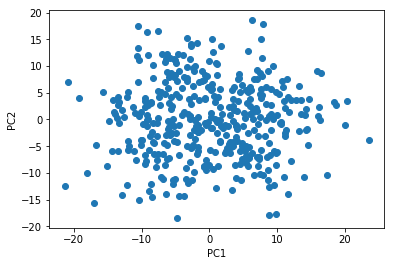

In [53]:
aa_rr = get_cleaned_match_df(agg_agg_folders[0])
aa_rr_minturns = get_games_min_num_turns(aa_rr)
fv_aa_rr = get_featurevector_gameset(aa_rr_minturns)

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(fv_aa_rr)

plt.plot(X_train_pca[:, 0], X_train_pca[:, 1], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [43]:
fv_aa_rr

,TURN_NO-0,P1_HEALTH-0,P2_HEALTH-0,CURRENT_PLAYER-0,AMOUNTHEALEDTHISTURN-0,NUMATTACKSTHISTURN-0,NUMCARDSDRAWNTHISTURN-0,NUMCARDSPLAYEDTHISTURN-0,NUMCARDSTODRAW-0,NUMELEMENTALSPLAYEDLASTTURN-0,NUMELEMENTALSPLAYEDTHISTURN-0,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-0,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-0,NUMMINIONSPLAYEDTHISTURN-0,NUMMINIONSPLAYERKILLEDTHISTURN-0,NUMOPTIONSPLAYEDTHISTURN-0,NUMSECRETSPLAYEDTHISGAME-0,NUMSPELLSPLAYEDTHISGAME-0,NUMTIMESHEROPOWERUSEDTHISGAME-0,REMAININGMANA-0,TOTALMANASPENTTHISGAME-0,USEDMANATHISTURN-0,TURN_NO-1,P1_HEALTH-1,P2_HEALTH-1,CURRENT_PLAYER-1,AMOUNTHEALEDTHISTURN-1,NUMATTACKSTHISTURN-1,NUMCARDSDRAWNTHISTURN-1,NUMCARDSPLAYEDTHISTURN-1,NUMCARDSTODRAW-1,NUMELEMENTALSPLAYEDLASTTURN-1,NUMELEMENTALSPLAYEDTHISTURN-1,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-1,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-1,NUMMINIONSPLAYEDTHISTURN-1,NUMMINIONSPLAYERKILLEDTHISTURN-1,NUMOPTIONSPLAYEDTHISTURN-1,NUMSECRETSPLAYEDTHISGAME-1,NUMSPELLSPLAYEDTHISGAME-1,NUMTIMESHEROPOWERUSEDTHISGAME-1,REMAININGMANA-1,TOTALMANASPENTTHISGAME-1,USEDMANATHISTURN-1,TURN_NO-2,P1_HEALTH-2,P2_HEALTH-2,CURRENT_PLAYER-2,AMOUNTHEALEDTHISTURN-2,NUMATTACKSTHISTURN-2,NUMCARDSDRAWNTHISTURN-2,NUMCARDSPLAYEDTHISTURN-2,NUMCARDSTODRAW-2,NUMELEMENTALSPLAYEDLASTTURN-2,NUMELEMENTALSPLAYEDTHISTURN-2,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-2,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-2,NUMMINIONSPLAYEDTHISTURN-2,NUMMINIONSPLAYERKILLEDTHISTURN-2,NUMOPTIONSPLAYEDTHISTURN-2,NUMSECRETSPLAYEDTHISGAME-2,NUMSPELLSPLAYEDTHISGAME-2,NUMTIMESHEROPOWERUSEDTHISGAME-2,REMAININGMANA-2,TOTALMANASPENTTHISGAME-2,USEDMANATHISTURN-2,TURN_NO-3,P1_HEALTH-3,P2_HEALTH-3,CURRENT_PLAYER-3,AMOUNTHEALEDTHISTURN-3,NUMATTACKSTHISTURN-3,NUMCARDSDRAWNTHISTURN-3,NUMCARDSPLAYEDTHISTURN-3,NUMCARDSTODRAW-3,NUMELEMENTALSPLAYEDLASTTURN-3,NUMELEMENTALSPLAYEDTHISTURN-3,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-3,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-3,NUMMINIONSPLAYEDTHISTURN-3,NUMMINIONSPLAYERKILLEDTHISTURN-3,NUMOPTIONSPLAYEDTHISTURN-3,NUMSECRETSPLAYEDTHISGAME-3,NUMSPELLSPLAYEDTHISGAME-3,NUMTIMESHEROPOWERUSEDTHISGAME-3,REMAININGMANA-3,TOTALMANASPENTTHISGAME-3,USEDMANATHISTURN-3,TURN_NO-4,P1_HEALTH-4,P2_HEALTH-4,CURRENT_PLAYER-4,AMOUNTHEALEDTHISTURN-4,NUMATTACKSTHISTURN-4,NUMCARDSDRAWNTHISTURN-4,NUMCARDSPLAYEDTHISTURN-4,NUMCARDSTODRAW-4,NUMELEMENTALSPLAYEDLASTTURN-4,NUMELEMENTALSPLAYEDTHISTURN-4,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-4,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-4,NUMMINIONSPLAYEDTHISTURN-4,NUMMINIONSPLAYERKILLEDTHISTURN-4,NUMOPTIONSPLAYEDTHISTURN-4,NUMSECRETSPLAYEDTHISGAME-4,NUMSPELLSPLAYEDTHISGAME-4,NUMTIMESHEROPOWERUSEDTHISGAME-4,REMAININGMANA-4,TOTALMANASPENTTHISGAME-4,USEDMANATHISTURN-4,TURN_NO-5,P1_HEALTH-5,P2_HEALTH-5,CURRENT_PLAYER-5,AMOUNTHEALEDTHISTURN-5,NUMATTACKSTHISTURN-5,NUMCARDSDRAWNTHISTURN-5,NUMCARDSPLAYEDTHISTURN-5,NUMCARDSTODRAW-5,NUMELEMENTALSPLAYEDLASTTURN-5,NUMELEMENTALSPLAYEDTHISTURN-5,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-5,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-5,NUMMINIONSPLAYEDTHISTURN-5,NUMMINIONSPLAYERKILLEDTHISTURN-5,NUMOPTIONSPLAYEDTHISTURN-5,NUMSECRETSPLAYEDTHISGAME-5,NUMSPELLSPLAYEDTHISGAME-5,NUMTIMESHEROPOWERUSEDTHISGAME-5,REMAININGMANA-5,TOTALMANASPENTTHISGAME-5,USEDMANATHISTURN-5,TURN_NO-6,P1_HEALTH-6,P2_HEALTH-6,CURRENT_PLAYER-6,AMOUNTHEALEDTHISTURN-6,NUMATTACKSTHISTURN-6,NUMCARDSDRAWNTHISTURN-6,NUMCARDSPLAYEDTHISTURN-6,NUMCARDSTODRAW-6,NUMELEMENTALSPLAYEDLASTTURN-6,NUMELEMENTALSPLAYEDTHISTURN-6,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-6,NUMFRIENDLYMINIONSTHATDIEDTHISTURN-6,NUMMINIONSPLAYEDTHISTURN-6,NUMMINIONSPLAYERKILLEDTHISTURN-6,NUMOPTIONSPLAYEDTHISTURN-6,NUMSECRETSPLAYEDTHISGAME-6,NUMSPELLSPLAYEDTHISGAME-6,NUMTIMESHEROPOWERUSEDTHISGAME-6,REMAININGMANA-6,TOTALMANASPENTTHISGAME-6,USEDMANATHISTURN-6,TURN_NO-7,P1_HEALTH-7,P2_HEALTH-7,CURRENT_PLAYER-7,AMOUNTHEALEDTHISTURN-7,NUMATTACKSTHISTURN-7,NUMCARDSDRAWNTHISTURN-7,NUMCARDSPLAYEDTHISTURN-7,NUMCARDSTODRAW-7,NUMELEMENTALSPLAYEDLASTTURN-7,NUMELEMENTALSPLAYEDTHISTURN-7,NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-7,NUMFRIENDLYMINIONSTH

In [41]:
aa_rr_comps, aa_rr_scaled = get_principal_components(fv_aa_rr)

Explained Variance Ratio:
[0.09866655 0.09498991]
Singular Values:
[62.66363506 61.48502494]


C:\Users\watson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


In [24]:
aa_rr_comps.sort_values('PC-1-ABS', ascending=False)#.head()

,PC-1,PC-2,PC-1-ABS,PC-2-ABS
NUMOPTIONSPLAYEDTHISTURN-5,-0.206526,-0.066660,0.206526,0.066660
NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-5,-0.194737,-0.037217,0.194737,0.037217
NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-7,-0.190890,-0.084144,0.190890,0.084144
NUMOPTIONSPLAYEDTHISTURN-7,-0.179305,-0.102456,0.179305,0.102456
NUMSPELLSPLAYEDTHISGAME-0,-0.172103,0.035633,0.172103,0.035633
P2_HEALTH-1,0.172103,-0.035633,0.172103,0.035633
P2_HEALTH-0,0.172103,-0.035633,0.172103,0.035633
NUMSPELLSPLAYEDTHISGAME-3,0.167390,0.098408,0.167390,0.098408
NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-6,0.165303,-0.132265,0.165303,0.132265
NUMOPTIONSPLAYEDTHISTURN-6,0.164191,-0.107870,0.164191,0.107870


In [120]:
aa_rr_comps.sort_values('PC-2-ABS', ascending=False).head()

,PC-1,PC-2,PC-1-ABS,PC-2-ABS
TOTALMANASPENTTHISGAME-2,0.053161,-0.237317,0.053161,0.237317
NUMOPTIONSPLAYEDTHISTURN-0,-0.030804,-0.221284,0.030804,0.221284
REMAININGMANA-0,0.030804,0.221284,0.030804,0.221284
USEDMANATHISTURN-0,-0.030804,-0.221284,0.030804,0.221284
TOTALMANASPENTTHISGAME-0,-0.030804,-0.221284,0.030804,0.221284


In [81]:
agg_agg_folders[1]

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\ZLvsCL_1k0_Compiled\\Roffle-Viper.csv'

C:\Users\watson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


Explained Variance Ratio:
[0.11698608 0.10863083]
Singular Values:
[62.22355901 59.96037112]


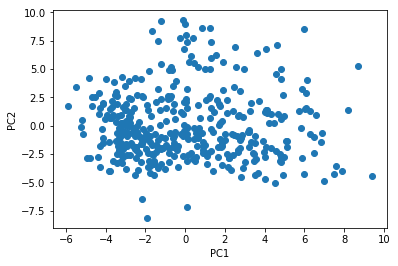

In [25]:
aa_rv = get_cleaned_match_df(agg_agg_folders[1])
aa_rv_minturns = get_games_min_num_turns(aa_rv)
fv_aa_rv = get_featurevector_gameset(aa_rv_minturns)
aa_rv_comps, aa_rv_scaled = get_principal_components(fv_aa_rv)
plt.scatter(aa_rv_scaled[:,0], aa_rv_scaled[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [28]:
aa_rr_comps.sort_values('PC-1-ABS', ascending=False).head()

,PC-1,PC-2,PC-1-ABS,PC-2-ABS
NUMOPTIONSPLAYEDTHISTURN-5,-0.206526,-0.066660,0.206526,0.066660
NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-5,-0.194737,-0.037217,0.194737,0.037217
NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-7,-0.190890,-0.084144,0.190890,0.084144
NUMOPTIONSPLAYEDTHISTURN-7,-0.179305,-0.102456,0.179305,0.102456
NUMSPELLSPLAYEDTHISGAME-0,-0.172103,0.035633,0.172103,0.035633


In [27]:
aa_rv_comps.sort_values('PC-1-ABS', ascending=False)#.head()

,PC-1,PC-2,PC-1-ABS,PC-2-ABS
NUMMINIONSPLAYEDTHISTURN-0,-0.243948,-5.923634e-02,0.243948,5.923634e-02
NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-2,-0.243948,-5.923634e-02,0.243948,5.923634e-02
P2_HEALTH-0,-0.243237,5.940602e-02,0.243237,5.940602e-02
P2_HEALTH-1,-0.243237,5.940602e-02,0.243237,5.940602e-02
NUMSPELLSPLAYEDTHISGAME-0,0.243237,-5.940602e-02,0.243237,5.940602e-02
NUMOPTIONSPLAYEDTHISTURN-4,-0.236259,-8.457167e-02,0.236259,8.457167e-02
NUMFRIENDLYMINIONSTHATATTACKEDTHISTURN-6,-0.218214,-4.097660e-02,0.218214,4.097660e-02
NUMSPELLSPLAYEDTHISGAME-2,0.215051,-1.212171e-01,0.215051,1.212171e-01
TOTALMANASPENTTHISGAME-4,-0.208813,-9.675921e-02,0.208813,9.675921e-02
NUMOPTIONSPLAYEDTHISTURN-6,-0.208264,2.253070e-02,0.208264,2.253070e-02


In [88]:
agg_agg_folders[2]

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\ZLvsCL_1k0_Compiled\\Roffle-Pizza.csv'

Explained Variance Ratio:
[0.11698608 0.10863083]
Singular Values:
[62.22355901 59.96037112]


C:\Users\watson\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by the scale function.
  


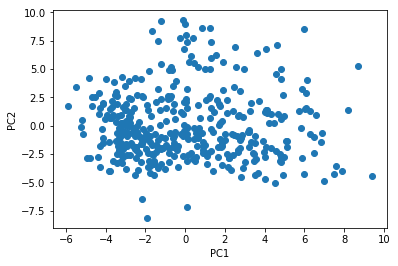

In [99]:
aa_rp = get_cleaned_match_df(agg_agg_folders[1])
aa_rp_minturns = get_games_min_num_turns(aa_rp)
fv_aa_rp = get_featurevector_gameset(aa_rp_minturns)
aa_rp_comps, aa_rp_scaled = get_principal_components(fv_aa_rp)
plt.scatter(aa_rp_scaled[:,0], aa_rp_scaled[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

# Aggro-Conrol PCA

In [56]:
agg_con_folders[0]

'C:\\Users\\watson\\Documents\\GitHub\\SabberStone-master\\Sabber_Work_2019F\\thesis-output\\SabberGameMatchups\\AvsC_1k0_Compiled\\Roffle-Orasha.csv'

min_n_turns is: 9


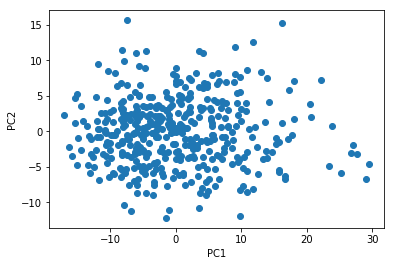

In [52]:
ac_ro = get_cleaned_match_df(agg_con_folders[0])
ac_ro_minturns = get_games_min_num_turns(ac_ro)
fv_ac_ro = get_featurevector_gameset(ac_ro_minturns)


pca = PCA(n_components=2)
Xc_train_pca = pca.fit_transform(fv_ac_ro)

plt.plot(Xc_train_pca[:, 0], Xc_train_pca[:, 1], 'o')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()









#ac_ro_comps, ac_ro_scaled = get_principal_components(fv_ac_ro)
#plt.scatter(ac_ro_scaled[:,0], ac_ro_scaled[:,1])
#plt.xlabel('PC1')
#plt.ylabel('PC2')
#plt.show()

# Aggro-Aggro Histograms of the Frequency of the Number of Turns

Note the histograms are saved to local folders

In [10]:
d_ = generate_histograms_score_matchup(agg_agg, 'Aggro-Aggro')

Roffle-Roffle (4060, 23)
Roffle-Viper (4216, 23)
Roffle-Pizza (4112, 23)
Roffle-Solegit (4177, 23)
Roffle-Wabeka (4323, 23)
Viper-Roffle (4221, 23)
Viper-Viper (4240, 23)
Viper-Pizza (4233, 23)
Viper-Solegit (4235, 23)
Viper-Wabeka (4509, 23)
Pizza-Roffle (4116, 23)
Pizza-Viper (4238, 23)
Pizza-Pizza (4216, 23)
Pizza-Solegit (4172, 23)
Pizza-Wabeka (4363, 23)
Solegit-Roffle (4088, 23)
Solegit-Viper (4263, 23)
Solegit-Pizza (4195, 23)
Solegit-Solegit (4162, 23)
Solegit-Wabeka (4371, 23)
Wabeka-Roffle (4373, 23)
Wabeka-Viper (4441, 23)
Wabeka-Pizza (4373, 23)
Wabeka-Solegit (4375, 23)
Wabeka-Wabeka (4664, 23)
Wrote histogram to: C:\Users\Main\Documents\GitHub\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-Aggro\Roffle-Roffle-Hist.jpg
Wrote histogram to: C:\Users\Main\Documents\GitHub\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-Aggro\Roffle-Viper-Hist.jpg
Wrote histogram to: C:\Users\Main\Documents\GitHub\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-Aggr

In [11]:
d_.keys()

dict_keys(['Roffle-Roffle', 'Roffle-Viper', 'Roffle-Pizza', 'Roffle-Solegit', 'Roffle-Wabeka', 'Viper-Roffle', 'Viper-Viper', 'Viper-Pizza', 'Viper-Solegit', 'Viper-Wabeka', 'Pizza-Roffle', 'Pizza-Viper', 'Pizza-Pizza', 'Pizza-Solegit', 'Pizza-Wabeka', 'Solegit-Roffle', 'Solegit-Viper', 'Solegit-Pizza', 'Solegit-Solegit', 'Solegit-Wabeka', 'Wabeka-Roffle', 'Wabeka-Viper', 'Wabeka-Pizza', 'Wabeka-Solegit', 'Wabeka-Wabeka'])

In [12]:
find_num_turn_outliers(d_)

Roffle-Roffle
The following are outliers: [15]
{'min': 8, 'q1': 9.0, 'q2': 10.0, 'q3': 11.0, 'max': 14}
_________
Roffle-Viper
The following are outliers: [16, 18]
{'min': 7, 'q1': 10.0, 'q2': 11.0, 'q3': 12.0, 'max': 15}
_________
Roffle-Pizza
The following are outliers: [7, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 16]
{'min': 9, 'q1': 10.0, 'q2': 10.0, 'q3': 11.0, 'max': 12}
_________
Roffle-Solegit
The following are outliers: []
{'min': 7, 'q1': 10.0, 'q2': 11.0, 'q3': 12.0, 'max': 14}
_________
Roffle-Wabeka
The following are outliers: [16, 16, 16, 18, 18, 20]
{'min': 7, 'q1': 10.0, 'q2': 11.0, 'q3': 12.0, 'max': 15}
_________
Viper-Roffle
The following are outliers: []
{'min': 8, 'q1': 10.0, 'q2': 11.0, 'q3': 12.0, 'max': 15}
_________
Viper-Viper
The following are outliers: [16, 17, 17]
{'min': 8, 'q1': 10.0, 'q2': 11.0, 'q3': 12.0, 'max': 15}
_________
Viper-Pizza
The following are outliers: [16]
{'min': 9, 'q1': 10.0, 'q2': 11.

In [19]:
agg_agg_wins = get_matchups_winrates(agg_agg, ngames=390)

Roffle-Roffle (4060, 23)
Roffle-Viper (4216, 23)
Roffle-Pizza (4112, 23)
Roffle-Solegit (4177, 23)
Roffle-Wabeka (4323, 23)
Viper-Roffle (4221, 23)
Viper-Viper (4240, 23)
Viper-Pizza (4233, 23)
Viper-Solegit (4235, 23)
Viper-Wabeka (4509, 23)
Pizza-Roffle (4116, 23)
Pizza-Viper (4238, 23)
Pizza-Pizza (4216, 23)
Pizza-Solegit (4172, 23)
Pizza-Wabeka (4363, 23)
Solegit-Roffle (4088, 23)
Solegit-Viper (4263, 23)
Solegit-Pizza (4195, 23)
Solegit-Solegit (4162, 23)
Solegit-Wabeka (4371, 23)
Wabeka-Roffle (4373, 23)
Wabeka-Viper (4441, 23)
Wabeka-Pizza (4373, 23)
Wabeka-Solegit (4375, 23)
Wabeka-Wabeka (4664, 23)


In [60]:
aa_wr_df = get_winrates_for_matchup_asframe(agg_agg_wins)
aa_wr_df

Roffle-Roffle 	 0.49230769230769234
Roffle-Viper 	 0.45384615384615384
Roffle-Pizza 	 0.5256410256410257
Roffle-Solegit 	 0.5102564102564102
Roffle-Wabeka 	 0.5538461538461539
Viper-Roffle 	 0.5
Viper-Viper 	 0.4641025641025641
Viper-Pizza 	 0.5102564102564102
Viper-Solegit 	 0.5615384615384615
Viper-Wabeka 	 0.6230769230769231
Pizza-Roffle 	 0.49743589743589745
Pizza-Viper 	 0.46923076923076923
Pizza-Pizza 	 0.4794871794871795
Pizza-Solegit 	 0.46923076923076923
Pizza-Wabeka 	 0.5794871794871795
Solegit-Roffle 	 0.4512820512820513
Solegit-Viper 	 0.44358974358974357
Solegit-Pizza 	 0.4717948717948718
Solegit-Solegit 	 0.4948717948717949
Solegit-Wabeka 	 0.5128205128205128
Wabeka-Roffle 	 0.4076923076923077
Wabeka-Viper 	 0.36153846153846153
Wabeka-Pizza 	 0.4846153846153846
Wabeka-Solegit 	 0.46153846153846156
Wabeka-Wabeka 	 0.5102564102564102


,P2-Roffle,P2-Viper,P2-Pizza,P2-Solegit,P2-Wabeka
P1-Roffle,0.492308,0.453846,0.525641,0.510256,0.553846
P1-Viper,0.5,0.464103,0.510256,0.561538,0.623077
P1-Pizza,0.497436,0.469231,0.479487,0.469231,0.579487
P1-Solegit,0.451282,0.44359,0.471795,0.494872,0.512821
P1-Wabeka,0.407692,0.361538,0.484615,0.461538,0.510256


In [65]:
aa_wr_arr = aa_wr_df.values.reshape(25, 1)
aa_wr_arr

array([[0.49230769230769234],
       [0.45384615384615384],
       [0.5256410256410257],
       [0.5102564102564102],
       [0.5538461538461539],
       [0.5],
       [0.4641025641025641],
       [0.5102564102564102],
       [0.5615384615384615],
       [0.6230769230769231],
       [0.49743589743589745],
       [0.46923076923076923],
       [0.4794871794871795],
       [0.46923076923076923],
       [0.5794871794871795],
       [0.4512820512820513],
       [0.44358974358974357],
       [0.4717948717948718],
       [0.4948717948717949],
       [0.5128205128205128],
       [0.4076923076923077],
       [0.36153846153846153],
       [0.4846153846153846],
       [0.46153846153846156],
       [0.5102564102564102]], dtype=object)

#### The below cells are for getting Aggro-Control Histograms of the Frequency of the Number of Turns

Note the histograms are saved to local folders

In [50]:
d_ac = generate_histograms_score_matchup(agg_con, 'Aggro-Control')

Roffle-Orasha (7955, 23)
Roffle-Thij (7996, 23)
Roffle-Stonekeep (7418, 23)
Roffle-Slage (7615, 23)
Roffle-Krebs1996 (7240, 23)
Viper-Orasha (8250, 23)
Viper-Thij (8053, 23)
Viper-Stonekeep (7555, 23)
Viper-Slage (7729, 23)
Viper-Krebs1996 (7505, 23)
Pizza-Orasha (8099, 23)
Pizza-Thij (8023, 23)
Pizza-Stonekeep (7550, 23)
Pizza-Slage (7506, 23)
Pizza-Krebs1996 (7309, 23)
Solegit-Orasha (8062, 23)
Solegit-Thij (7726, 23)
Solegit-Stonekeep (7406, 23)
Solegit-Slage (7487, 23)
Solegit-Krebs1996 (7285, 23)
Wabeka-Orasha (8486, 23)
Wabeka-Thij (8367, 23)
Wabeka-Stonekeep (7401, 23)
Wabeka-Slage (7746, 23)
Wabeka-Krebs1996 (7909, 23)
Wrote histogram to: C:\Users\Main\Documents\GitHub\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-Control\Roffle-Orasha-Hist.jpg
Wrote histogram to: C:\Users\Main\Documents\GitHub\Sabber_Work_2019F\thesis-output\num-turns-per-game\Aggro-Control\Roffle-Thij-Hist.jpg
Wrote histogram to: C:\Users\Main\Documents\GitHub\Sabber_Work_2019F\thesis-output\num-tu

In [51]:
agg_con_wins = get_matchups_winrates(agg_con, ngames=390)

Roffle-Orasha (7955, 23)
Roffle-Thij (7996, 23)
Roffle-Stonekeep (7418, 23)
Roffle-Slage (7615, 23)
Roffle-Krebs1996 (7240, 23)
Viper-Orasha (8250, 23)
Viper-Thij (8053, 23)
Viper-Stonekeep (7555, 23)
Viper-Slage (7729, 23)
Viper-Krebs1996 (7505, 23)
Pizza-Orasha (8099, 23)
Pizza-Thij (8023, 23)
Pizza-Stonekeep (7550, 23)
Pizza-Slage (7506, 23)
Pizza-Krebs1996 (7309, 23)
Solegit-Orasha (8062, 23)
Solegit-Thij (7726, 23)
Solegit-Stonekeep (7406, 23)
Solegit-Slage (7487, 23)
Solegit-Krebs1996 (7285, 23)
Wabeka-Orasha (8486, 23)
Wabeka-Thij (8367, 23)
Wabeka-Stonekeep (7401, 23)
Wabeka-Slage (7746, 23)
Wabeka-Krebs1996 (7909, 23)


In [98]:
agg_agg_matchups_arr = np.array(  ['{}{}'.format(m.split('-')[0][:2], m.split('-')[1][:2]) for m in list(agg_agg_wins.keys())] )
agg_con_matchups_arr = np.array(  ['{}{}'.format(m.split('-')[0][:2], m.split('-')[1][:2]) for m in list(agg_con_wins.keys())] )

In [54]:
ac_wrdf = get_winrates_for_matchup_asframe(agg_con_wins)
ac_wrdf

Roffle-Orasha 	 0.05641025641025641
Roffle-Thij 	 0.12564102564102564
Roffle-Stonekeep 	 0.21025641025641026
Roffle-Slage 	 0.1358974358974359
Roffle-Krebs1996 	 0.08974358974358974
Viper-Orasha 	 0.2
Viper-Thij 	 0.24102564102564103
Viper-Stonekeep 	 0.30256410256410254
Viper-Slage 	 0.3
Viper-Krebs1996 	 0.18717948717948718
Pizza-Orasha 	 0.14615384615384616
Pizza-Thij 	 0.25384615384615383
Pizza-Stonekeep 	 0.2512820512820513
Pizza-Slage 	 0.35384615384615387
Pizza-Krebs1996 	 0.18461538461538463
Solegit-Orasha 	 0.1564102564102564
Solegit-Thij 	 0.2076923076923077
Solegit-Stonekeep 	 0.23076923076923078
Solegit-Slage 	 0.2641025641025641
Solegit-Krebs1996 	 0.16153846153846155
Wabeka-Orasha 	 0.36666666666666664
Wabeka-Thij 	 0.4564102564102564
Wabeka-Stonekeep 	 0.5307692307692308
Wabeka-Slage 	 0.5282051282051282
Wabeka-Krebs1996 	 0.3153846153846154


,P2-Orasha,P2-Thij,P2-Stonekeep,P2-Slage,P2-Krebs1996
P1-Roffle,0.0564103,0.125641,0.210256,0.135897,0.0897436
P1-Viper,0.2,0.241026,0.302564,0.3,0.187179
P1-Pizza,0.146154,0.253846,0.251282,0.353846,0.184615
P1-Solegit,0.15641,0.207692,0.230769,0.264103,0.161538
P1-Wabeka,0.366667,0.45641,0.530769,0.528205,0.315385


In [68]:
ac_wr_arr = ac_wrdf.values.reshape(25,1)
ac_wr_arr

array([[0.05641025641025641],
       [0.12564102564102564],
       [0.21025641025641026],
       [0.1358974358974359],
       [0.08974358974358974],
       [0.2],
       [0.24102564102564103],
       [0.30256410256410254],
       [0.3],
       [0.18717948717948718],
       [0.14615384615384616],
       [0.25384615384615383],
       [0.2512820512820513],
       [0.35384615384615387],
       [0.18461538461538463],
       [0.1564102564102564],
       [0.2076923076923077],
       [0.23076923076923078],
       [0.2641025641025641],
       [0.16153846153846155],
       [0.36666666666666664],
       [0.4564102564102564],
       [0.5307692307692308],
       [0.5282051282051282],
       [0.3153846153846154]], dtype=object)

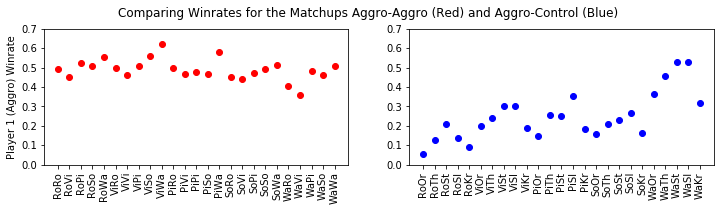

In [114]:
plt.figure(figsize=(12,3))
plt.subplot(121)
#plt.plot(np.arange(0,1, 0.04), aa_wr_arr, 'o', color='red', label='Agg-Agg')
plt.plot(agg_agg_matchups_arr, aa_wr_arr, 'o', color='red', label='Agg-Agg')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 0.8, 0.1))
plt.ylabel('Player 1 (Aggro) Winrate')
plt.subplot(122)
plt.plot(agg_con_matchups_arr, ac_wr_arr, 'o', color='blue', label='Agg-Con')
plt.xticks(rotation=90)
plt.yticks(np.arange(0, 0.8, 0.1))

plt.suptitle('Comparing Winrates for the Matchups Aggro-Aggro (Red) and Aggro-Control (Blue)')
plt.gcf().subplots_adjust(bottom=0.25)
#txt = 'The x-label shows the unique matchups from P1 to P2, where the players\' names are denoted by the first two letters of their name.'
#plt.gcf().text(0.5, -0.2, txt, ha='center')
plt.savefig('C:\\Users\\Main\\Documents\\GitHub\\Sabber_Work_2019F\\thesis-images\\comparing-winrates-base-scores.jpg')
plt.show()

In [95]:
agg_con_matchups_arr

array(['RO', 'RT', 'RS', 'RS', 'RK', 'VO', 'VT', 'VS', 'VS', 'VK', 'PO',
       'PT', 'PS', 'PS', 'PK', 'SO', 'ST', 'SS', 'SS', 'SK', 'WO', 'WT',
       'WS', 'WS', 'WK'], dtype='<U2')

### Collecting the data for Aggro-Control matchups

In [8]:
acdf = agg_con.get_all_matchup_summary_data()
acdf

Roffle-Orasha (7955, 23)
Roffle-Thij (7996, 23)
Roffle-Stonekeep (7418, 23)
Roffle-Slage (7615, 23)
Roffle-Krebs1996 (7240, 23)
Viper-Orasha (8250, 23)
Viper-Thij (8053, 23)
Viper-Stonekeep (7555, 23)
Viper-Slage (7729, 23)
Viper-Krebs1996 (7505, 23)
Pizza-Orasha (8099, 23)
Pizza-Thij (8023, 23)
Pizza-Stonekeep (7550, 23)
Pizza-Slage (7506, 23)
Pizza-Krebs1996 (7309, 23)
Solegit-Orasha (8062, 23)
Solegit-Thij (7726, 23)
Solegit-Stonekeep (7406, 23)
Solegit-Slage (7487, 23)
Solegit-Krebs1996 (7285, 23)
Wabeka-Orasha (8486, 23)
Wabeka-Thij (8367, 23)
Wabeka-Stonekeep (7401, 23)
Wabeka-Slage (7746, 23)
Wabeka-Krebs1996 (7909, 23)


,Roffle-Orasha,Roffle-Thij,Roffle-Stonekeep,Roffle-Slage,Roffle-Krebs1996,Viper-Orasha,Viper-Thij,Viper-Stonekeep,Viper-Slage,Viper-Krebs1996,Pizza-Orasha,Pizza-Thij,Pizza-Stonekeep,Pizza-Slage,Pizza-Krebs1996,Solegit-Orasha,Solegit-Thij,Solegit-Stonekeep,Solegit-Slage,Solegit-Krebs1996,Wabeka-Orasha,Wabeka-Thij,Wabeka-Stonekeep,Wabeka-Slage,Wabeka-Krebs1996
Mean-Num-Turns,20.449871,20.555270,19.069409,19.575835,18.611825,21.208226,20.701799,19.421594,19.868895,19.293059,20.820051,20.624679,19.408740,19.295630,18.789203,20.724936,19.861183,19.038560,19.246787,18.727506,21.814910,21.508997,19.025707,19.912596,20.331620
Median-Num-Turns,20.000000,20.000000,20.000000,20.000000,18.000000,21.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,21.000000,20.000000,20.000000,19.000000,18.000000,22.000000,22.000000,20.000000,20.000000,21.000000
Var-Num-Turns,9.840908,15.670262,20.322490,16.409827,11.119551,13.727149,20.276827,27.208398,24.444107,18.290184,11.493308,19.951554,22.257758,22.146914,15.254419,15.467959,17.856969,20.753664,19.717290,14.193597,19.125447,24.760872,32.050884,19.337702,18.680982
Std-Num-Turns,3.137022,3.958568,4.508047,4.050904,3.334599,3.705017,4.502980,5.216167,4.944098,4.276702,3.390178,4.466716,4.717813,4.706051,3.905691,3.932933,4.225751,4.555619,4.440416,3.767439,4.373265,4.976030,5.661350,4.397465,4.322150
Num-Games,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000,390.000000


In [18]:
acdf.loc[('Mean-Num-Turns', 'Roffle-Orasha')]

20.44987146529563

In [74]:
mt1 = 'Roffle-Krebs1996'
mt2 = 'Roffle-Wabeka'
mean_dif = diff_in_means(acdf, sdf, mt1, mt2)
samp = samp_stat(acdf, sdf, mt1, mt2, 1.65)
print('mean dif', mean_dif)
print('z*samp_var', samp)

Roffle-Krebs1996 3.334599005287553
Roffle-Wabeka 1.6269501670293665
Roffle-Krebs1996 390.0
Roffle-Wabeka 390.0
Std sampling distribution is 0.1878796489576923
mean dif 7.498714652956297
z*samp_var 0.31000142078019227
